# Imports and loading in test file

In [ ]:
import numpy as np
import scipy.signal as signal
import wave
import struct
import librosa
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

import wave
import numpy as np
import matplotlib.pyplot as plt
import sys

from ipywidgets import * # interactive plots

In [ ]:
## Loading in audio file
input_signal, sr = librosa.load('/content/drive/MyDrive/SPAI - google colab documents/1759.wav', sr=44100, mono=True, duration = 10);

## Audio data information
print("Amount of samples n =", input_signal.shape[0])
print("Sample rate fs =", sr)
print("Audio Length in seconds = %d s \n" % (input_signal.shape[0]/sr))

## Playback audio file
ipd.Audio(input_signal, rate=sr)

Amount of samples n = 441000
Sample rate fs = 44100
Audio Length in seconds = 10 s 



# Reverb

In [ ]:
## Schroeder reverberation algorithms

def allpass(input_signal, delay, gain):
    # Formula: y[n] = a*x[n] + x[n - delay] - a*[n-M]

    b = np.zeros(delay)
    b[0] = gain
    b[-1] = 1
    a = np.zeros(delay)
    a[0] = 1
    a[-1] = gain
    return signal.lfilter(b, a, input_signal)

def comb(input_signal, delay, gain):
  # Formula: y[n] = x[n] - a*x[n-delay]
    # Initialize the filter coefficients
    a = gain
    
    # Initialize the delay buffer
    buffer = np.zeros(delay+1)
    
    # Initialize the output signal
    output_signal = np.zeros(len(input_signal))
    
    # Apply the filter to the input signal
    for i in range(len(input_signal)):
        
        # Compute the current output
        current_output = input_signal[i] + a*buffer[delay]
        
        # Update the delay buffer
        buffer[1:] = buffer[:-1]
        buffer[0] = current_output
        
        # Save the current output
        output_signal[i] = current_output
    
    return output_signal

def early_reflections_fir(input_signal):
    # Customize the filter parameters here
    delay_samples = [100, 300, 400, 500]
    gain = [0.8, 0.6, 0.5, 0.3]
    amplitude = 0.5
    
    # Initialize the filter coefficients
    filter_coeffs = np.zeros(max(delay_samples) + 1)
    
    # Compute the filter coefficients for each reflection
    for i in range(len(delay_samples)):
        delay = delay_samples[i]
        reflection_gain = gain[i]
        filter_coeffs[delay] += reflection_gain
    
    # Normalize the filter coefficients
    filter_coeffs /= np.sum(filter_coeffs)
    
    # Pad the input signal with zeros to allow for the filter delay
    input_signal_padded = np.concatenate((input_signal, np.zeros(len(filter_coeffs) - 1)))
    
    # Initialize the output signal
    filtered_signal = np.zeros_like(input_signal)
    
    # Apply the filter to the input signal
    for n in range(len(filtered_signal)):
        filtered_signal[n] = np.sum(input_signal_padded[n:n+len(filter_coeffs)] * filter_coeffs)
    
    # Scale the output signal by the overall amplitude
    filtered_signal *= amplitude
    
    return filtered_signal

def lowpass(signal, cutoff_frequency):

    # Compute filter coefficient
    dt = 1 / sr
    rc = 1 / (2 * np.pi * cutoff_frequency)
    alpha = dt / (dt + rc)

    # Apply filter to input signal
    output = np.zeros(len(signal))
    output[0] = signal[0]

    for n in range(1, len(signal)):
        output[n] = alpha * signal[n] + (1 - alpha) * output[n - 1]

    return output

In [ ]:
def reverb(input_signal, wet):
  # Early reflections are based upon moorer design, while late reflections is the part of Schroeder
  early_reflections = early_reflections_fir(input_signal)

  comb1 = comb(input_signal,1601,0.8)
  comb2 = comb(input_signal,1687,0.8)
  comb3 = comb(input_signal,2053,0.8)
  comb4 = comb(input_signal,2251,0.8)

  sum_comb = comb1 + comb2 + comb3 + comb4

  late_reflections_AP = allpass((sum_comb*0.25),347,0.75)

  output_signal = input_signal + (1-wet)*early_reflections + wet*late_reflections_AP

  return output_signal

In [ ]:
scaled = np.int16(reverb(input_signal,1) / np.max(np.abs(reverb(input_signal,1))) * 32767)
write('test.wav', sr, scaled)

In [ ]:
## Playback audio file
ipd.Audio('test.wav', rate=sr)

# Graph EQ

In [ ]:
import scipy


In [ ]:
w0 = np.pi*500;

In [ ]:
b,a = scipy.signal.iirpeak(0.4, 10, fs=2.0)

In [ ]:
signal.TransferFunction(b,a)

TransferFunctionContinuous(
array([ 0.0591907,  0.       , -0.0591907]),
array([ 1.        , -0.58145212,  0.88161859]),
dt: None
)

In [ ]:
w,h = scipy.signal.freqz(b,a);

In [ ]:
import matplotlib.pyplot as plt

<ipython-input-13-0670ded9933b>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


Text(0.5, 0, 'Frequency [rad/sample]')

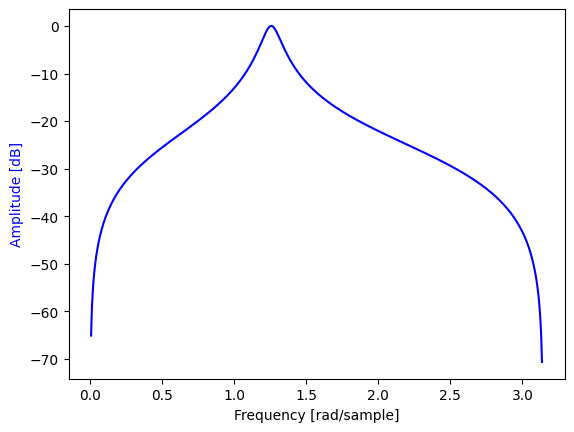

In [ ]:
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')

In [ ]:
#IIR Peaking filter source: https://www.dummies.com/article/business-careers-money/careers/trades-tech-engineering-careers/how-to-characterize-the-peaking-filter-for-an-audio-graphic-equalizer-165341/

def iir_peaking(fc, Q, gain):
    # Calculate the coefficients for the peaking filter
    mu = np.power(10,gain/20)

    wc = np.pi * fc * 2 
    kq = (4/(1+mu)) * np.tan(wc/(2*Q))

    b1 = (-2*np.cos(wc)) / (1+kq*mu)
    b2 = (1-kq*mu) / (1+kq*mu)

    a1 = (-2*np.cos(wc)) / (1+kq)
    a2 = (1-kq)/(1+kq)

    Cpk = (1+kq*mu) / (1+kq)

    return [b1/a1, b2], [a1/a1, a2] , Cpk

In [ ]:
b,a,Cpk = iir_peaking(500,0.7,-10)

print(b[0],a[0],b[1],a[1],Cpk)

x = np.zeros(2) # Delay line of 2 elements, since we need z**(-1) and z**(-2)
output_signal = np.zeros(input_signal.shape[0])

for i in range(input_signal.shape[0]):
  x[1] = x[0]
  x[0] = input_signal[i]

  output_signal[i] = Cpk + Cpk*b[0]/a[0] * x[0] + Cpk*b[1]/a[1] * x[1]

2.1816845790160118 1.0 -0.09299984991196018 -0.5842661405723841 0.4583614009184693


In [ ]:
scaled = np.int16(output_signal / np.max(np.abs(output_signal)) * 32767)
write('test_2.wav', sr, scaled)

In [ ]:
## Playback audio file
ipd.Audio('test_2.wav', rate=sr)

# Pitch shifting

In [ ]:
def pitch_shift(input_WAV, factor, sample_rate):
    output_WAV = np.zeros(len(input_WAV))
    circular_buffer_length = 256
    circ_buf = np.zeros(circular_buffer_length)
    write_index = 0
    read_index = 0
    write_period = 1.0 / sample_rate
    read_period = write_period * factor
    for i in range(0, len(input_WAV)):
        # Write to the circular buffer.
        # To reduce the audible clicks when the two pointers cross we average the
        # existing value with the new value.
        circ_buf[write_index] = (circ_buf[write_index] + input_WAV[i]) / 2
        #circ_buf[write_index] = input_WAV[i]
        if write_index == circular_buffer_length - 1:
            write_index = 0
        else:
            write_index += 1

        # Calc the next read index on the circular buffer.
        t = i * write_period
        ri = t / read_period
        read_index = int(ri % circular_buffer_length)

        # Read from the circular buffer with different pitch.
        output_WAV[i] = circ_buf[read_index]

    return output_WAV

In [ ]:
output = pitch_shift(input_signal, 1.5, 44100)

In [ ]:
scaled = np.int16(output / np.max(np.abs(output)) * 32767)
write('test_3.wav', sr, scaled)

In [ ]:
## Playback audio file
ipd.Audio('test_3.wav', rate=sr)

In [ ]:
#Source Yet Another Electronics Channel (Pitch shift on the STM)

def pitch_shift_v2(input_WAV, shift_factor, sample_rate):
  output_WAV = np.zeros(len(input_WAV))

  # Set circular buffer length and overlap
  circular_buffer_length = 512
  circ_buf = np.zeros(circular_buffer_length)
  overlap = 128

  # initial variables
  crossfade = 1
  write_index = 0
  read_index = 0


  for i in range(0, len(input_WAV)):
    #write to the circular buffer. 
    circ_buf[write_index] = input_WAV[i]

    #generate fractional readpointer and generate 0° and 180° read-pointer in integer
    read_index_int = round(read_index)
    read_index2 = 0

    if (read_index_int >= circular_buffer_length/2):
      read_index2_int = read_index_int - (circular_buffer_length//2) 
    else:
      read_index2_int = read_index_int + (circular_buffer_length//2)

    #Read both samples
    read_index_sample = float(circ_buf[read_index_int])
    read_index2_sample = float(circ_buf[read_index2_int])

    # Check if first readpointer starts overlap with write pointer?
    # if yes -> do cross-fade to second read-pointer
    if ( (write_index - read_index_int) < overlap ) and ((write_index - read_index_int) > 0) and (shift_factor != 1.):
      rel = int(write_index - read_index_int)
      crossfade = float(rel) / float(overlap)
    elif ((write_index - read_index_int) == 0):
      crossfade = 0.

    # Check if second readpointer starts overlap with write pointer?
    # if yes -> do cross-fade to second read-pointer
    if ( (write_index - read_index2_int) < overlap ) and ((write_index - read_index2_int) > 0) and (shift_factor != 1.):
      rel = int(write_index - read_index2_int)
      crossfade = 1. - float(rel) / float(overlap)
    elif ((write_index - read_index2_int) == 0):
      crossfade = 1.

    #do cross-fading and sum up
    sum = (read_index_sample*crossfade + read_index2_sample*(1-crossfade))

	  #increment fractional read-pointer and write-pointer
    read_index = read_index + shift_factor
    write_index = write_index + 1
    
    if (write_index == circular_buffer_length):
     write_index = 0
     
    if (round(read_index) >= circular_buffer_length):
     read_index = 0.

    output_WAV[i] = sum

  return output_WAV

In [ ]:
output2 = pitch_shift_v2(input_signal, 1.5, 44100)

In [ ]:
scaled = np.int16(output2 / np.max(np.abs(output2)) * 32767)
write('test_4.wav', sr, scaled)

In [ ]:
## Playback audio file
ipd.Audio('test_4.wav', rate=sr)

In [ ]:
#Source Yet Another Electronics Channel (Pitch shift on the STM)

def pitch_shift_v3(input_WAV, shift_factor, sample_rate):
  output_WAV = np.zeros(len(input_WAV))

  # Set circular buffer length and overlap
  circular_buffer_length = 1024
  circ_buf = np.zeros(circular_buffer_length)
  circ_buf2 = np.zeros(circular_buffer_length)
  overlap = 64

  # initial variables
  crossfade = 1
  write_index = 0
  read_index = 0
  read_index2 = circular_buffer_length/2; #180° phase shift


  for i in range(0, len(input_WAV)):
    #write to the circular buffer. 
    circ_buf[write_index] = input_WAV[i]
    circ_buf2[write_index] = input_WAV[i]

    # Increment write address - simulate circ buffer
    write_index = write_index + 1
    
    if (write_index == circular_buffer_length):
     write_index = 0

    #increment fractional read-pointer and write-pointer
    read_index = read_index + shift_factor

    if (read_index >= circular_buffer_length/2):
      read_index2 = read_index - (circular_buffer_length/2) 
    else:
      read_index2 = read_index + (circular_buffer_length/2)
    

    if (read_index >= (circular_buffer_length-1) ):
      read_index = 0.

    if (read_index2 >= (circular_buffer_length-1) ):
      read_index2 = 0.

    # update fractional index
    read_index_int = round(read_index)
    read_index2_int = round(read_index2)

    #Read both samples
    read_index_sample = float(circ_buf[read_index_int])
    read_index2_sample = float(circ_buf2[read_index2_int])

    if ( shift_factor > 1):
      # if shift_factor > 1, this means that readpointer is faster than write pointer and we have to track  write pointer - read pointer (index distance)

      # Check if first readpointer starts overlap with write pointer?
      # if yes -> do cross-fade to second read-pointer
      if ( (write_index - read_index_int) < overlap ) and ((write_index - read_index_int) > 0):
        rel = int(write_index - read_index_int)
        crossfade = float(rel) / float(overlap)
      elif ((write_index - read_index_int) == 0):
        crossfade = 0.

      # Check if second readpointer starts overlap with write pointer?
      # if yes -> do cross-fade to second read-pointer
      if ( (write_index - read_index2_int) < overlap ) and ((write_index - read_index2_int) > 0):
        rel = int(write_index - read_index2_int)
        crossfade = 1. - float(rel) / float(overlap)
      elif ((write_index - read_index2_int) == 0):
        crossfade = 1.
    else:
      # else shift_factor < 1, this means that writepointer is faster than read pointer and we have to track read pointer - write pointer (index distance)

      if ( (read_index_int - write_index) < overlap ) and ((read_index_int - write_index) > 0):
        rel = int(read_index_int - write_index)
        crossfade = float(rel) / float(overlap)
      elif ((read_index_int - write_index) == 0):
        crossfade = 0.
      
      # 
      if ( (read_index2_int - write_index) < overlap ) and ((read_index2_int - write_index) > 0):
        rel = int(read_index2_int - write_index)
        crossfade = 1. - float(rel) / float(overlap)
      elif ((read_index2_int - write_index) == 0):
        crossfade = 1.


    #do cross-fading and sum up
    sum = (read_index_sample*crossfade + read_index2_sample*(1-crossfade))    

    output_WAV[i] = sum

  return output_WAV

In [ ]:
output3 = pitch_shift_v3(input_signal, 1.5, 44100)

In [ ]:
scaled = np.int16(output3 / np.max(np.abs(output3)) * 32767)
write('test_5.wav', sr, scaled)

In [ ]:
## Playback audio file
ipd.Audio('test_5.wav', rate=sr)

# ANF-LMS algorithm (see MATLAB and C code)